## Deep QNetworks

Deep Qlearning with experience replay.

things to do:
- correct render methods in env
- provide info about body in buffer and as output of step
- create separate function for render and epsilon_greedy (use get_obs for all the info you need)
- merge these functions and some rules of the game in a separate class Agent


In [1]:
import sys
sys.path.insert(0, '/home/alexserra98/uni/r_l/project/Deep-QNetworks/src_code')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import copy
from qnetworks import ReplayBuffer
from buffers import VecReplayBuffer
from deep_qnetworks import DQN , SnakeEnv, SnakeAgent
from tqdm import tqdm
import gymnasium as gym
from gymnasium import spaces
import pickle

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 32  # Size of batch taken from replay buffer

In [4]:
NUM_ENVS = 3

## Set up

In [18]:
# initialize the environment 
Lx = 10
Ly = 10

envs =  gym.vector.AsyncVectorEnv([
    lambda: SnakeEnv(size =(Lx,Ly))
    for _ in range(NUM_ENVS)
], context='fork')

# Initialize the models
model = DQN(in_channels =1, num_actions=envs.single_action_space.n, input_size=envs.single_observation_space.spaces["agent"].high[0])
# The target model makes the prediction of future rewards.
# The weights of a target model get updated every 10000 steps thus when the
# loss between the Q-values is calculated the target Q-value is stable.
model_target = DQN(in_channels = 1, num_actions=envs.single_action_space.n, input_size=envs.single_observation_space.spaces["agent"].high[0])

model.to(device)
model_target.to(device)

# In the Deepmind paper they use RMSProp however then Adam optimizer
# improves training time
optimizer = torch.optim.Adam(model.parameters(), lr=0.00025)
# huber loss
loss_function = nn.HuberLoss()

# Train hyperparameters

cur_frame = 0
last_100_ep_rewards = []
max_steps_per_episode = 100
max_num_episodes = 100
envs = gym.wrappers.RecordEpisodeStatistics(envs, deque_size=max_num_episodes)

# Train the model after 4 actions
update_after_actions = 4
# How often to update the target network
update_target_network = 10

# Number of frames to take random action and observe output
epsilon_random_frames = 50000
# Number of frames for exploration
epsilon_greedy_frames = 100000.0

filename = 'dqn_results.txt'

# Initialize the agent
num_actions = envs.single_action_space.n
#action_space = spaces.Discrete(4)
learning_rate = 0.01
initial_epsilon = 1.0

epsilon_decay = initial_epsilon / (max_num_episodes / 2) 
final_epsilon = 0.1
snake_agent = SnakeAgent(learning_rate, initial_epsilon, epsilon_decay, final_epsilon, num_actions, (Lx,Ly), 0.95, envs, NUM_ENVS)

## Train

In [19]:
def train_step(states, actions, rewards, next_states, dones, bodies, new_bodies, discount):
    """
    Perform a training iteration on a batch of data sampled from the experience
    replay buffer.

    Takes as input:
        - states: a batch of states
        - actions: a batch of actions
        - rewards: a batch of rewards
        - next_states: a batch of next states
        - dones: a batch of dones
        - discount: the discount factor, standard discount factor in RL to evaluate less long term rewards
    """

    # compute targets for Q-learning
    # the max Q-value of the next state is the target for the current state
    # the image to be fed to the network is a grey scale image of the world
    images = [snake_agent.get_image(next_state, new_body) for next_state, new_body in zip(next_states,new_bodies)]
    input = torch.as_tensor(np.array(images), dtype=torch.float32).unsqueeze(1).to(device)
    max_next_qs = snake_agent.model_target(input).max(-1).values

    # if the next state is terminal, then the Q-value is just the reward
    # otherwise, we add the discounted max Q-value of the next state
    target = rewards + (1.0 - dones) * snake_agent.discount_factor * max_next_qs

    # then to compute the loss, we also need the Q-value of the current state
    images = [snake_agent.get_image(state, body) for state, body in zip(states,bodies)]
    input = torch.as_tensor(np.array(images), dtype=torch.float32).unsqueeze(1).to(device)
    qs = snake_agent.model(input)

    # for each state, we update ONLY the Q-value of the action that was taken

    #action_masks = F.one_hot(torch.as_tensor(np.array(actions)).long(), num_actions)
    action_masks = F.one_hot(actions.long(), num_actions)
    masked_qs = (action_masks * qs).sum(dim=-1)
    loss = loss_function(masked_qs, target.detach())
    snake_agent.training_error.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

In [20]:
# initialize the buffer, with a size of 100000, when it is full, it will remove the oldest element
buffer = VecReplayBuffer(size = 100000, device=device) 

for episode in tqdm(range(max_num_episodes)):
    envs.reset()
    #episode_reward = 0

    timestep = 0

    while timestep < max_steps_per_episode:
    
        cur_frame += 1
 
        agent = np.stack(envs.get_attr("_agent_location"))
        target = np.stack(envs.get_attr("_target_location"))
        states = np.concatenate((agent,target),axis=1)
        bodies = list(envs.get_attr("body"))
        actions = snake_agent.get_mult_action(states, bodies)
        
        next_states, rewards, dones, _, new_bodies = envs.step(actions)
        next_states = np.concatenate((next_states["agent"],next_states["target"]),axis=1)
        #episode_reward += rewards
        new_bodies = list(new_bodies["body"])

                
        # Save actions and states in replay buffer
        buffer.add_multiple(states, actions, rewards, next_states, dones, bodies, new_bodies)

        cur_frame += 1

        Train neural network.
        if len(buffer) > batch_size and cur_frame % update_after_actions == 0:
            states, actions, rewards, next_states, dones, bodies, new_bodies = buffer.sample(batch_size)
            loss = train_step(states, actions, rewards, next_states, dones, bodies, new_bodies, discount=0.99)
        
        # Update target network every update_target_network steps.
        if cur_frame % update_target_network == 0:
            snake_agent.model_target.load_state_dict(model.state_dict())

        timestep += 1
    snake_agent.decay_epsilon()
    
    # if len(last_100_ep_rewards) == 100:
    #     last_100_ep_rewards = last_100_ep_rewards[1:]
    # last_100_ep_rewards.append(episode_reward)

    # running_reward = np.mean(last_100_ep_rewards)

    if ((episode+1) % 100) == 0:
        # write on file current average reward
        with open(filename, 'a') as f:
            f.write(f'{episode},{running_reward:.2f}, {snake_agent.epsilon:.3f}\n')
        
        metrics ={'return_queue': envs.return_queue, 'length_queue': envs.length_queue, 'training_error': snake_agent.training_error}
        with open('metrics.pickle', 'wb') as handle:
            pickle.dump(metrics, handle)
        
        # do we want to save it every 100 episodes? dunno it's up to you
        torch.save(snake_agent.model.state_dict(), 'model.pt')

    # Condition to consider the task solved
    # e.g. to eat at least 6 consecutive food items
    # without eating itself, considering also the moves to reach the food
    if running_reward > 500: 
        print("Solved at episode {}!".format(episode))
        break

100%|██████████| 100/100 [06:31<00:00,  3.91s/it]


ValueError: v cannot be empty

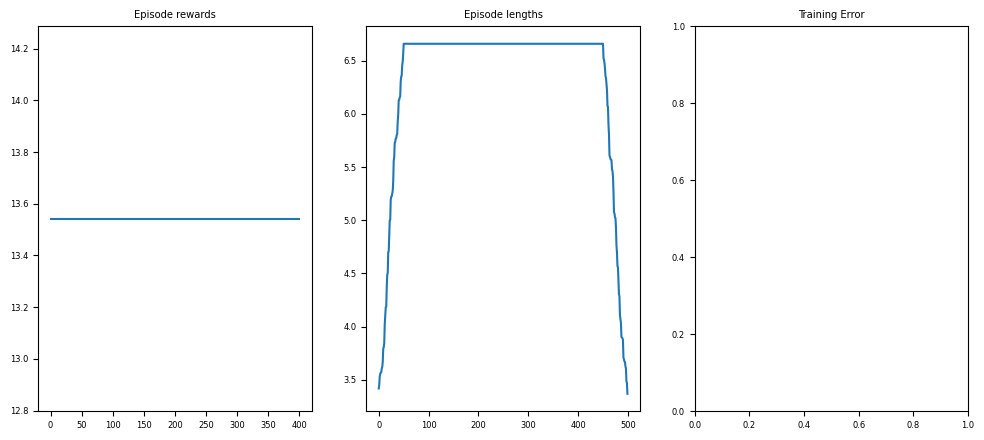

In [23]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(envs.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(envs.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(snake_agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()